In [1]:
import neilpy
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import apply_parallel
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats import itemfreq
import pandas as pd

Start by loading a sample DEM.  I downloaded an area near <a href="https://en.wikipedia.org/wiki/Mount_Washington_(New_Hampshire)" target="_blank">Mt. Washington, New Hampshire</a> from the National Map, and reprojected it into Mercator.

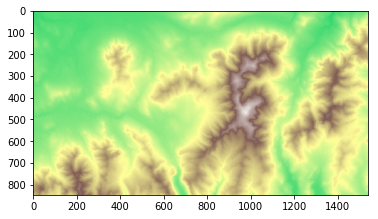

In [2]:
with rasterio.open('../sample_data/sample_dem.tif') as src:
    Z = src.read(1)
    Zt = src.affine

plt.imshow(Z,cmap='terrain',vmin=-500,vmax=2000)
plt.show()

Geomorphons are terrain classes that correspond to particular kinds of terrain.  These kinds include peaks, valleys, ridges, and so on.  A peak, for example, is defined by a high central pixel with lower surrounding pixels.  A slope is defined by an area where about half of the surrounding pixels are higher than a central pixel, and abouth half are lower.  The neighborhood of a geomorphon is supplied by the user, and "higher or lower" is calculated by openness.  For the full range of geomorphons, see Figures 3 and 4 from <a href="https://doi.org/10.1016/j.geomorph.2012.11.005" target="_blank">Jasiewicz and Stepinksi's paper</a>.  The user also needs to supply an angle as a threshold value for determining whether a surrounding pixel is "near flat", so the geomorphon calculation is ternary (a neighboring pixel is higher, about flat, or lower).

Following an <A href="http://sil.uc.edu/geom/app" target="_blank">online implementation</a> of geomorphons, results are keyed in the following way:

1 – flat, 2 – peak, 3 - ridge, 4 – shoulder, 5 – spur, 6 – slope, 7 – hollow, 8 – footslope, 9 – valley, and 10 – pit

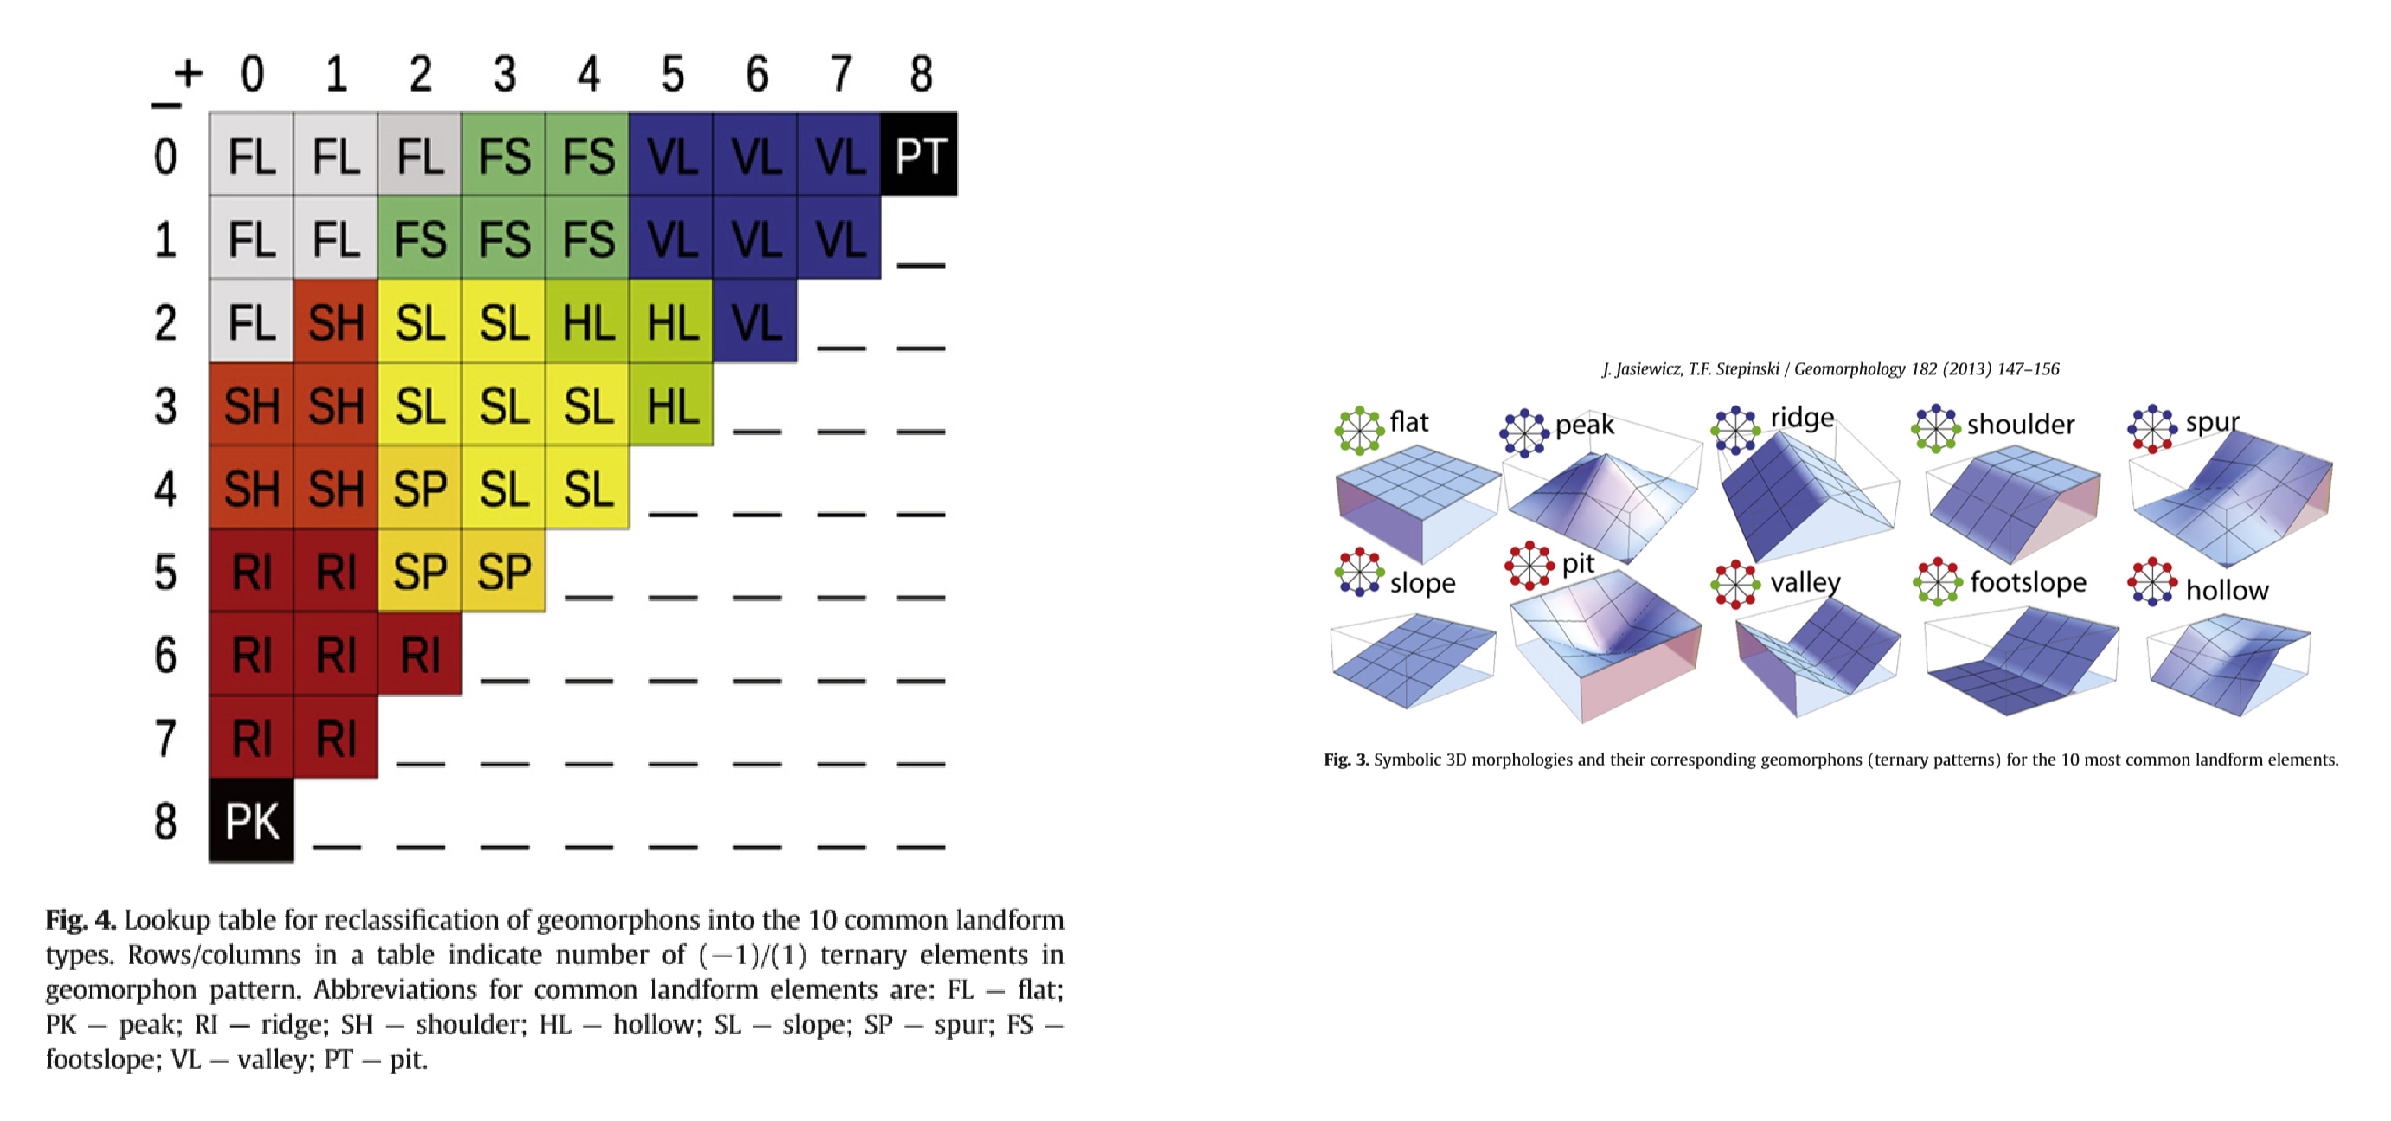

In [3]:
plt.figure(figsize=((10,5)),dpi=300)
plt.subplot(121)
fig = plt.imshow(plt.imread('../develop/geomorphons_fig4.png'))
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

plt.subplot(122)
fig = plt.imshow(plt.imread('../develop/geomorphons_fig3.png'))
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

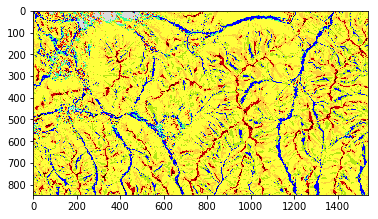

In [19]:
# Calculate the geomorphons (a numeric code, 1-10, as a numpy array)
G = neilpy.get_geomorphon_from_openness(Z,cellsize=Zt[0],lookup_pixels=25,threshold_angle=1)

# Apply a "standard" colormap and display the image
im = Image.fromarray(G,mode='L')
im.putpalette(neilpy.geomorphon_cmap())
plt.imshow(im)
plt.show()

# Save the image
plt.imsave('sample_dem_geomorphons.png',im)
neilpy.write_worldfile(Zt,'sample_dem_geomorphons.pgw')

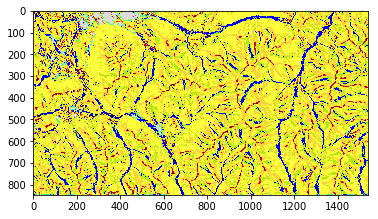

In [20]:
# Compare to an image processed through the online portal: http://sil.uc.edu/geom/app

with rasterio.open('../sample_data/sample_dem_geomorphons.tif') as src:
    G2 = src.read(1)
im = Image.fromarray(G2,mode='L')
im.putpalette(neilpy.geomorphon_cmap())
plt.imshow(im)
plt.show()

In [6]:
np.sum(G==G2) / np.size(G2)

0.79369662214998693

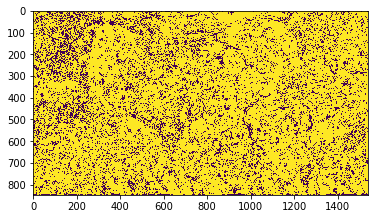

In [21]:
plt.imshow(G==G2)

# Openness

Geomorphons relies on an openness calculation, where openness is essentially the average angular view of the sky at a given point.  Openness uses a neighborhood distance (supplied by the user), and searches along the 8 primary directions (N, NE, E, etc.) up to the distance limit (in pixels) of the neighborhood.  Positive openness for a given axis is the angular view from the pixel to the highest point along that axis, and the positive openness value for a pixel is the average of the 8 axes.  Negative openness is the angle from nadir to the lowest point along the axis.  Geomorphons uses the difference between positive and negative openness as the basis for its calculation.

Rather than implementing negative openness separately, it is calculated as the positive openness of the negative DEM.

In [7]:
O_pos = neilpy.openness(Z,cellsize=Zt[0],lookup_pixels=20)
O_neg = neilpy.openness(-Z,cellsize=Zt[0],lookup_pixels=20)

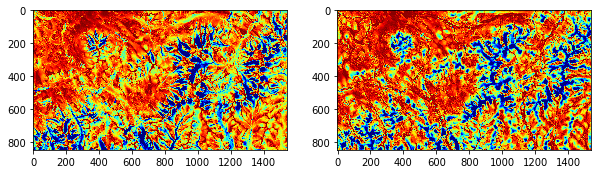

In [8]:
plt.figure(figsize=((10,5)))
plt.subplot(121)
plt.imshow(O_pos,cmap='jet',vmin=np.percentile(O_pos,5),vmax=np.percentile(O_pos,95))
plt.subplot(122)
plt.imshow(O_neg,cmap='jet',vmin=np.percentile(O_neg,5),vmax=np.percentile(O_neg,95))
plt.show()

## A Closer Look at Geomorphons

Geomorphons follows several other interprations of terrain as topological relationships between a pixel and its neighbors.  For other examples, see <a href="https://doi.org/10.1080/15230406.2016.1164625" target="_blank">Clarke and Romero (2017)</a> and <a href="https://scholar.google.com/scholar?q=The+Geomorphological+Characterisation+of+Digital+Elevation+Models&hl=en&as_sdt=0&as_vis=1&oi=scholart&sa=X&ved=0ahUKEwjlyoXFjdjYAhWB0YMKHRk0AwkQgQMIJzAA" target="_blank">Wood's dissertation work (1996)</a>.  For these examples, cellsize is assumed a default of 1, and a slope threshold of 1.

[[1 1 1]
 [1 2 1]
 [1 1 1]]
Geomorphon code: 2


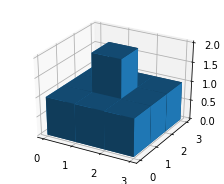

In [9]:
# Given a small, 3x3 neighborhood of a "peak", calculate a geomorphon for the central pixel

ZI = np.array([[1,1,1],[1,2,1],[1,1,1]])
G = neilpy.get_geomorphon_from_openness(ZI,lookup_pixels=1)

print(ZI)
print('Geomorphon code:',G[1,1])

# Block visualization
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
x,y = np.meshgrid(np.arange(3),np.arange(3))
ax1.bar3d(x.ravel(), y.ravel(), np.zeros_like(ZI.ravel()), 1, 1, ZI.ravel(), shade=True)

plt.show()

In [10]:
# Use Figure 3 from J&S to design and test any 3D morphology
# 1 – flat, 2 – peak, 3 - ridge, 4 – shoulder, 5 – spur, 6 – slope, 7 – hollow, 8 – footslope, 9 – valley, and 10 – pit

ZI = np.array([[0,0,0],[2,1,2],[2,2,2]])
G = neilpy.get_geomorphon_from_openness(ZI,lookup_pixels=1)

print(ZI)
print('Geomorphon code:',G[1,1])

[[0 0 0]
 [2 1 2]
 [2 2 2]]
Geomorphon code: 7


In [99]:
ZI = np.array([[0,0,0],[0,1,0],[0,0,0]])
G = neilpy.get_geomorphons(ZI,lookup_pixels=1)

print(ZI)
print('Geomorphon code:',G[1,1])

[[0 0 0]
 [0 1 0]
 [0 0 0]]
Geomorphon code: 10


In [11]:
# The geomorphons classification is actually a great simplification of the topology of terrain.  It happens that only the 
# ternary classification is counted, and the arrangement of highs and lows is irrelevant:

# This is a slope
ZI = np.array([[0,0,0],[1,1,1],[2,2,2]])
G = neilpy.get_geomorphon_from_openness(ZI,lookup_pixels=1)
print('Geomorphon code:',G[1,1])

# But this is a more complex terrain, classified as slope because it has the same number of "highs" and "lows"
ZI = np.array([[0,1,2],[2,1,0],[0,1,2]])
G = neilpy.get_geomorphon_from_openness(ZI,lookup_pixels=1)
print('Geomorphon code:',G[1,1])

Geomorphon code: 6
Geomorphon code: 6


In [13]:
# To retrieve the full terrain code classification, first generate a ternary pattern (from openness or another routine), and 
# then find the lowest reflectional and rotational equivlent:

ZI = np.array([[0,0,0],[1,1,1],[2,2,2]])
TC = neilpy.ternary_pattern_from_openness(ZI,lookup_pixels=1)
print("Original terrain code: ",TC[1,1])
TC = neilpy.ternary_pattern_from_openness(ZI,lookup_pixels=1,lowest=True)
print("Original terrain code: ",TC[1,1])

Original terrain code:  2240
Original terrain code:  160


## Frequencies of terrain codes

Most of the terrain codes fall into only a few categories; this is why most qualitative descriptions of terrain contain only 8-10 categories. J&S report that the 30 most common geomorphons (terrain codes) correspond to about 85% of all cells.

In [14]:
with rasterio.open('../sample_data/sample_dem.tif') as src:
    Z = src.read(1)
    Zt = src.affine
TC = neilpy.ternary_pattern_from_openness(Z,cellsize=Zt[0],lookup_pixels=20,threshold_angle=1,lowest=True)
df = pd.DataFrame(itemfreq(TC),columns=['terrain_code','num'])
df = df.sort_values(by='num',ascending=False)
df.head(10)

,terrain_code,num
35,80,387007
97,242,160128
80,161,149325
29,53,117949
14,26,106075
79,160,48117
235,728,29069
206,485,28988
5,8,26056
11,17,25145


The top 30 categories are 92.784 % of the data.


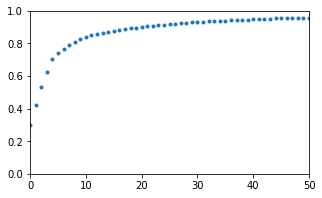

In [16]:
% matplotlib inline
n = 30
x = 100 * np.sum(df.num.values[:n]) / np.sum(df.num)

print("The top",n,"categories are",'{:0.3f}'.format(x),"% of the data.")

plt.figure(figsize=(5,3))
plt.plot(np.cumsum(df.num.values)/np.sum(df.num),'.')
_ = plt.xlim((0,50))
_ = plt.ylim((0,1))

## How it works

While J&S implemented a filter for geomorphons, we use a directional shifting function to move a partial copy of entire array in a direction clockwise from NE-to-SE (0) to W-to-E (8).  This means that the every shift is repeated only once, making the entire solution only 8 * pixel_distance shifts.  However, it requires 8 copies of the array to be created, so it is somewhat more memory intensive than a pure neighborhood filter approach.

In [17]:
# Openness and Geomorphons use ashift to calculate, which moves the array in a direction (1-8) specified by the user.
# The user can also specify how many pixels (n) to shift
x = np.arange(25).reshape((5,5))
print(x)
print(neilpy.ashift(x,direction=0,n=1))

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[[ 0  1  2  3  4]
 [ 5  0  1  2  3]
 [10  5  6  7  8]
 [15 10 11 12 13]
 [20 15 16 17 18]]
